# Solving `CartPole`

#### Your task:


Solve the `CartPole` environment. Which algorithms could you use? As a warm-up, implement first SARSA or Q-Learning in `FrozenLake`. 

Some starter code is below. Note that if you want to use these algorithms for `CartPole` you need to discretize the state space somehow.   

In [197]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gym
import math

### How could you know how to discretize?

You can try to sample some elements from the observation space (=state space). Then discretize based on that.

In [198]:
cp_env = gym.make('CartPole-v0')
cp_obs = [cp_env.observation_space.sample() for _ in range(10000)]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Text(0.5,1,'Observation x')

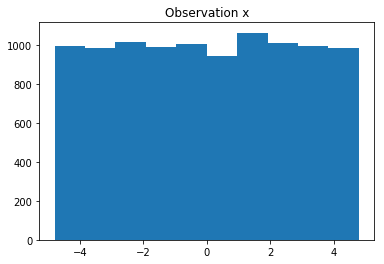

In [199]:
plt.hist([ob[0] for ob in cp_obs] )
plt.title("Observation x")

Text(0.5,1,'Observation x_dot')

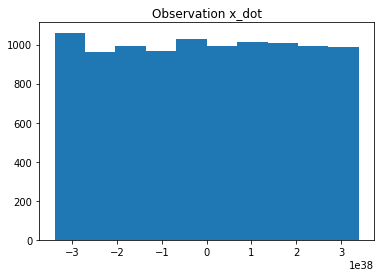

In [200]:
plt.hist([ob[1] for ob in cp_obs] )
plt.title("Observation x_dot")

Text(0.5,1,'Observation theta')

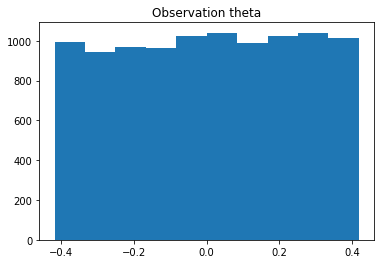

In [201]:
plt.hist([ob[2] for ob in cp_obs] )
plt.title("Observation theta")

Text(0.5,1,'Observation theta_dot')

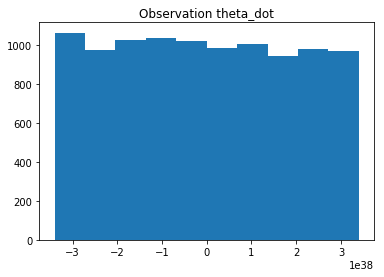

In [202]:
plt.hist([ob[3] for ob in cp_obs] )
plt.title("Observation theta_dot")

Then, we define some limit for the borders.

In [203]:
STATE_BOUNDS = list(zip(cp_env.observation_space.low, cp_env.observation_space.high))
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]
NUM_BUCKETS = (1,1,6,3) # state:n_bins pairs

In [204]:
def obs_to_state(obs):
    bucket_indice = []
    for i in range(len(obs)):
        if obs[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif obs[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*obs[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

In [205]:
def epsilon_greedy_policy(Q, epsilon, actions):
    """ Q is a numpy array, epsilon between 0,1 
    and a list of actions"""
    
    def policy_fn(state):
        if np.random.rand()>epsilon and np.max(Q[state])>0: #avoid getting stuck in the initial step
            action = np.argmax(Q[state])
        else:
            action = np.random.choice(actions)
        return action
    return policy_fn


env = gym.make("CartPole-v0")
n_episodes = 1000
gamma = 0.999

# Initialization
Q = np.zeros(NUM_BUCKETS+(env.action_space.n,))

actions = range(env.action_space.n)
alpha = 0.5


score = []    
for ep in range(n_episodes):
    done = False
    
    obs = env.reset()
    state = obs_to_state(obs)
    
    policy = epsilon_greedy_policy(Q, epsilon=1/(ep+1) if ep<100 else 0, actions = actions )
    

    
    ### Generate sample episode
    
    t = 0
    ep_reward = 0
    
    while not done:

        action = policy(state)    
        new_obs, reward, done, _ =  env.step(action)
        new_state = obs_to_state(new_obs)
        
        if done:
            Q[state+(action,)] = Q[state+(action,)] + alpha*(reward - Q[state+(action,)])
        else:
            Q[state+(action,)] = Q[state+(action,)] + alpha*(reward + gamma*np.max(Q[new_state]) - Q[state+(action,)])
        
        
        # Update rewards and state. Remember that CartPole is an on-going task!
        ep_reward += reward
        state = new_state 
        
        if done:
            if len(score) < 100:
                score.append(ep_reward)
            else:
                score[ep % 100] = ep_reward
                
            if (ep+1) % 100 == 0:
                print("Number of episodes: {} . Average 100-episode reward: {}".format(ep+1, np.mean(score)))
           

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of episodes: 100 . Average 100-episode reward: 55.66
Number of episodes: 200 . Average 100-episode reward: 200.0
Number of episodes: 300 . Average 100-episode reward: 200.0
Number of episodes: 400 . Average 100-episode reward: 200.0
Number of episodes: 500 . Average 100-episode reward: 199.98
Number of episodes: 600 . Average 100-episode reward: 200.0
Number of episodes: 700 . Average 100-episode reward: 199.97
Number of episodes: 800 . Average 100-episode reward: 200.0
Number of episodes: 900 . Average 100-episode reward: 200.0
Number of episodes: 1000 . Average 100-episode reward: 200.0
